In [1]:
import regression as r

In [2]:
icgem_data_gravity_ell = r.hm.load_icgem_gdf("data/south-atlantic/gravity_ell_EIGEN-6C4_5356c5f42a312695eabd65ae655e9dff12a23b3d7abf04a75ffcf294a8d022ba.gdf")
icgem_data_topography = r.hm.load_icgem_gdf("data/south-atlantic/topography_grd_etopo1-2250_4266472118e1ccb246e3435eeba94f22f0c59330cacc3a5fafbba452ed726c6d.gdf")
icgem_data_geoid = r.hm.load_icgem_gdf("data/south-atlantic/geoid_EIGEN-6C4_dad5641c3390b1ed3d9778f1575d22361bfe6e80ab465785af9ced6f09617d2b.gdf")

In [3]:
data = r.xr.merge(
    [icgem_data_gravity_ell.rename({'gravity_ell': 'gravity'}), icgem_data_topography.rename({'topography_grd': 'topography'}), icgem_data_geoid]
)

In [4]:
gamma = r.bl.WGS84.normal_gravity(data.latitude, 10000) # gravidade teórica da Terra elipsoidal

disturbance = data.gravity - gamma # medido pelo gravímetro subtraido pela teórica

topography_adjust = data.topography + data.geoid # ajustando a diferença de topografia entre geoide e elipsoide, a altura do geoide é em relação ao elipsoide

bouguer_corr = r.hm.bouguer_correction(topography_adjust)

data['dg_bouguer'] = disturbance - bouguer_corr

data

<xarray.Dataset> Size: 6MB
Dimensions:          (latitude: 346, longitude: 401)
Coordinates:
  * latitude         (latitude) float64 3kB -57.0 -56.8 -56.6 ... 11.6 11.8 12.0
  * longitude        (longitude) float64 3kB -57.0 -56.8 -56.6 ... 22.8 23.0
Data variables:
    gravity          (latitude, longitude) float64 1MB 9.786e+05 ... 9.752e+05
    height_over_ell  (latitude, longitude) float64 1MB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 1MB -4.207e+03 ... 651.0
    geoid            (latitude, longitude) float64 1MB 19.83 19.82 ... 4.775
    dg_bouguer       (latitude, longitude) float64 1MB 320.2 277.7 ... -70.66
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/05
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.7864506E+05 mgal
    minvalue:              9.7490335E+05 mgal
    signal_wrms:           1.0805756E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [5]:
topo_raw = data.topography.values.ravel()
dg_raw = data.dg_bouguer.values.ravel()
    
region = r.vd.get_region((data.longitude.values, data.latitude.values))
lon_grid, lat_grid = r.vd.grid_coordinates(region=region, shape=data.topography.shape, meshgrid=True)
lon_raw, lat_raw = lon_grid.ravel(), lat_grid.ravel()

mask = ~r.np.isnan(topo_raw) & ~r.np.isnan(dg_raw)
h, d = topo_raw[mask], dg_raw[mask]
lon, lat = lon_raw[mask], lat_raw[mask]

In [22]:
df_windows, indices = r.windows_regression(data, h, d, lon, lat, window_size=4.0, overlap=0.5, min_points = 4)
df_windows.to_csv('df_windows.csv')

df_windows_mixed_coefs = df_windows.dropna(subset = ['a_o', 'a_c', 'b'])
df_windows_mixed_coefs.to_csv('df_windows_mixed_coefs.csv')

df_windows_ocean = df_windows[df_windows['a_c'].isna()]
df_windows_ocean.to_csv('df_windows_ocean.csv')

df_windows_continent = df_windows[df_windows['a_o'].isna()]
df_windows_continent.to_csv('df_windows_continent.csv')

df_fodase = df_windows[df_windows['r2'] < 0.7]
df_fodase.to_csv('df_fodase.csv')

print(f' \nMédia de pontos no oceano por janela: {r.np.mean(df_windows.ocean_points)}')
print(f'Média de pontos no continente por janela: {r.np.mean(df_windows.continent_points)}\n')


v_o = 0.06
print(f'\nJanelas de oceano com coeficiente maiores que |{v_o}|: {len(df_windows.a_o[(df_windows.a_o < -v_o) | (df_windows.a_o > v_o)])}')

v_c = 1
print(f'Janelas de continente com coeficiente maiores que |{v_c}|: {len(df_windows.a_c[(df_windows.a_c < -v_c) | (df_windows.a_c > v_c)])}')

v_r = 0.6
print(f'Janelas com r2 < {v_r}: {len(df_windows[df_windows.r2 < v_r])}\n')


#df_windows[(df_windows.a_o < -v_o) | (df_windows.a_o > v_o)]
#df_windows[(df_windows.a_c < -v_c) | (df_windows.a_c > v_c)]

df_windows_continent[df_windows_continent.r2 < v_r]



 0 janelas foram ignoradas por falta de dados.
 
Média de pontos no oceano por janela: 370.671146953405
Média de pontos no continente por janela: 93.71774193548387


Janelas de oceano com coeficiente maiores que |0.06|: 862
Janelas de continente com coeficiente maiores que |1|: 0
Janelas com r2 < 0.6: 41



,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
0,-53.513106,-55.0,-0.076976,NaN,-17.453791,0.979512,0,735,735,0
1,-50.035668,-55.0,-0.076632,NaN,-16.332078,0.983531,1,735,735,0
2,-46.558229,-55.0,-0.077472,NaN,-17.332503,0.977099,2,735,735,0
3,-43.080790,-55.0,-0.075120,NaN,-6.579980,0.981265,3,735,735,0
4,-39.603352,-55.0,-0.067735,-0.097732,18.862767,0.976239,4,735,721,14
...,...,...,...,...,...,...,...,...,...,...
1111,12.759602,10.0,NaN,-0.108023,7.513235,0.977352,1111,420,0,420
1112,14.811988,10.0,NaN,-0.103164,1.443020,0.887279,1112,441,0,441
1113,16.864374,10.0,NaN,-0.116205,0.127250,0.756944,1113,420,0,420
1114,18.916760,10.0,NaN,-0.111974,-6.762642,0.598908,1114,420,0,420


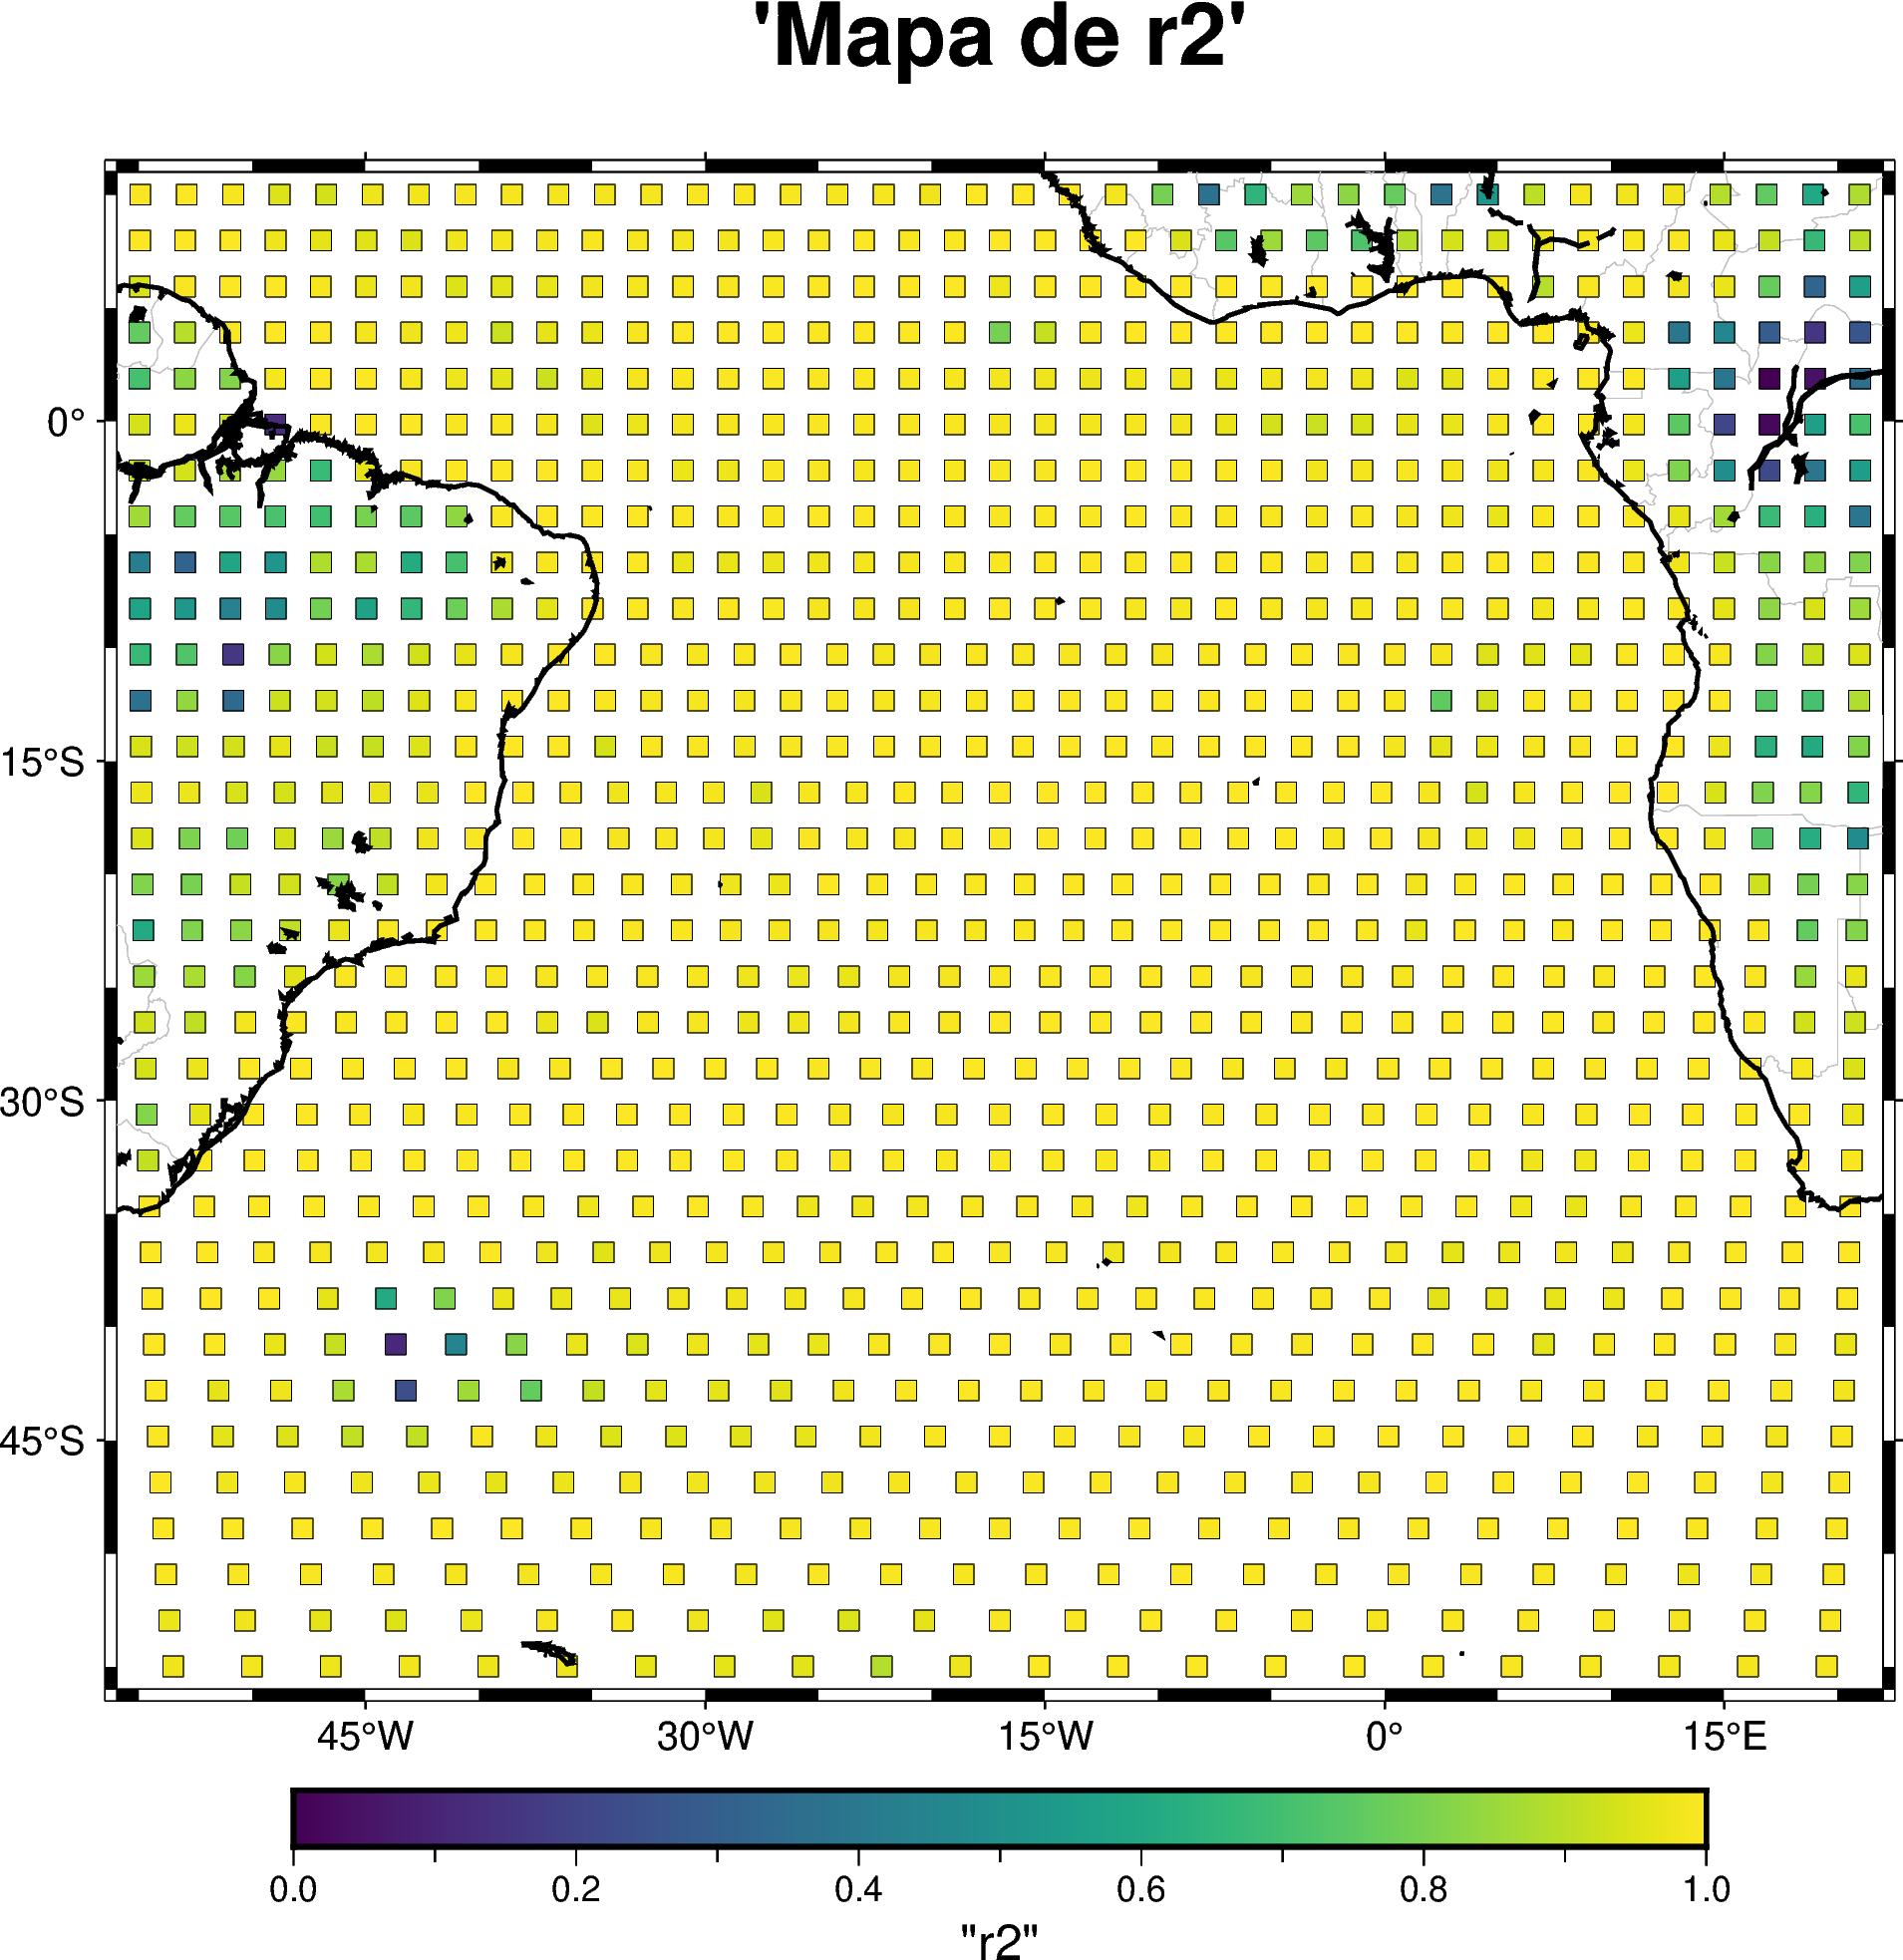

In [7]:
fig_r2 = r.plot_parameters_map(df_windows, 'r2', v_range = [0, 1], step = 0.01, cmap='viridis', reverse=False, projection = 'Q')
fig_r2.coast(shorelines='1p,black')
fig_r2.savefig('mapa-r2.png')

fig_a_o = r.plot_parameters_map(df_windows, 'a_o', v_range = [-1, 1], step = 0.01, cmap = 'polar', reverse = False, projection = 'Q')
fig_a_o.coast(shorelines = '0.5p,black')
fig_a_o.savefig('mapa-a_o.png')

fig_a_c = r.plot_parameters_map(df_windows, 'a_c', v_range = [-2, 2], step = 0.01, cmap = 'polar', reverse = False, projection = 'Q')
fig_a_c.coast(shorelines = '0.5p,black')
fig_a_c.savefig('mapa-a_c.png')


fig_r2.show()

# Acessando a janela mais próxima dadas as coordenadas

In [17]:
# achando janela mais próxima a um ponto dada a coordenada 
lon_window = 15
lat_window = 0


distances = r.np.sqrt((df_windows['longitude'] - lon_window)**2 + (df_windows['latitude'] - lat_window)**2)

distances

window_minor_distance = distances.idxmin()
line_in_df_minor_distance = df_windows.loc[df_windows['original-idx'] == window_minor_distance]

line_in_df_minor_distance


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
918,14.999994,-0.15625,NaN,-0.04838,-37.729505,0.207437,918,420,0,420


In [18]:
idx_current = indices[window_minor_distance][0]
idx_current

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

idx_sort = r.np.argsort(h_window_raw)
h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window, min_points = 5)
a_ocean_window, a_continent_window, intercept_window, r2_window = p_window

p_window

(nan,
 np.float64(-0.04838028473262404),
 np.float64(-37.7295045395112),
 np.float64(0.2074372827705968))

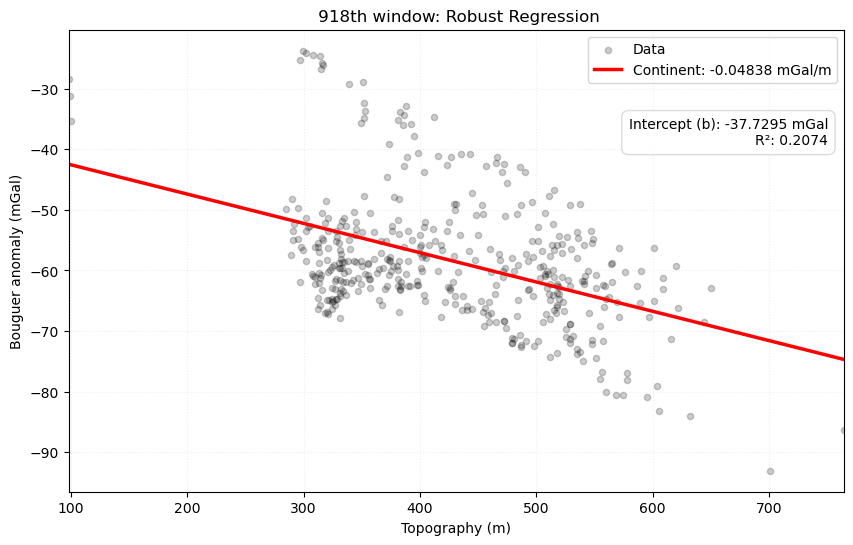

In [19]:
r.plot_window_regression(window_minor_distance, h_window, d_window, a_ocean_window, a_continent_window, intercept_window, r2_window)

O círculo rosa é a localização da janela.



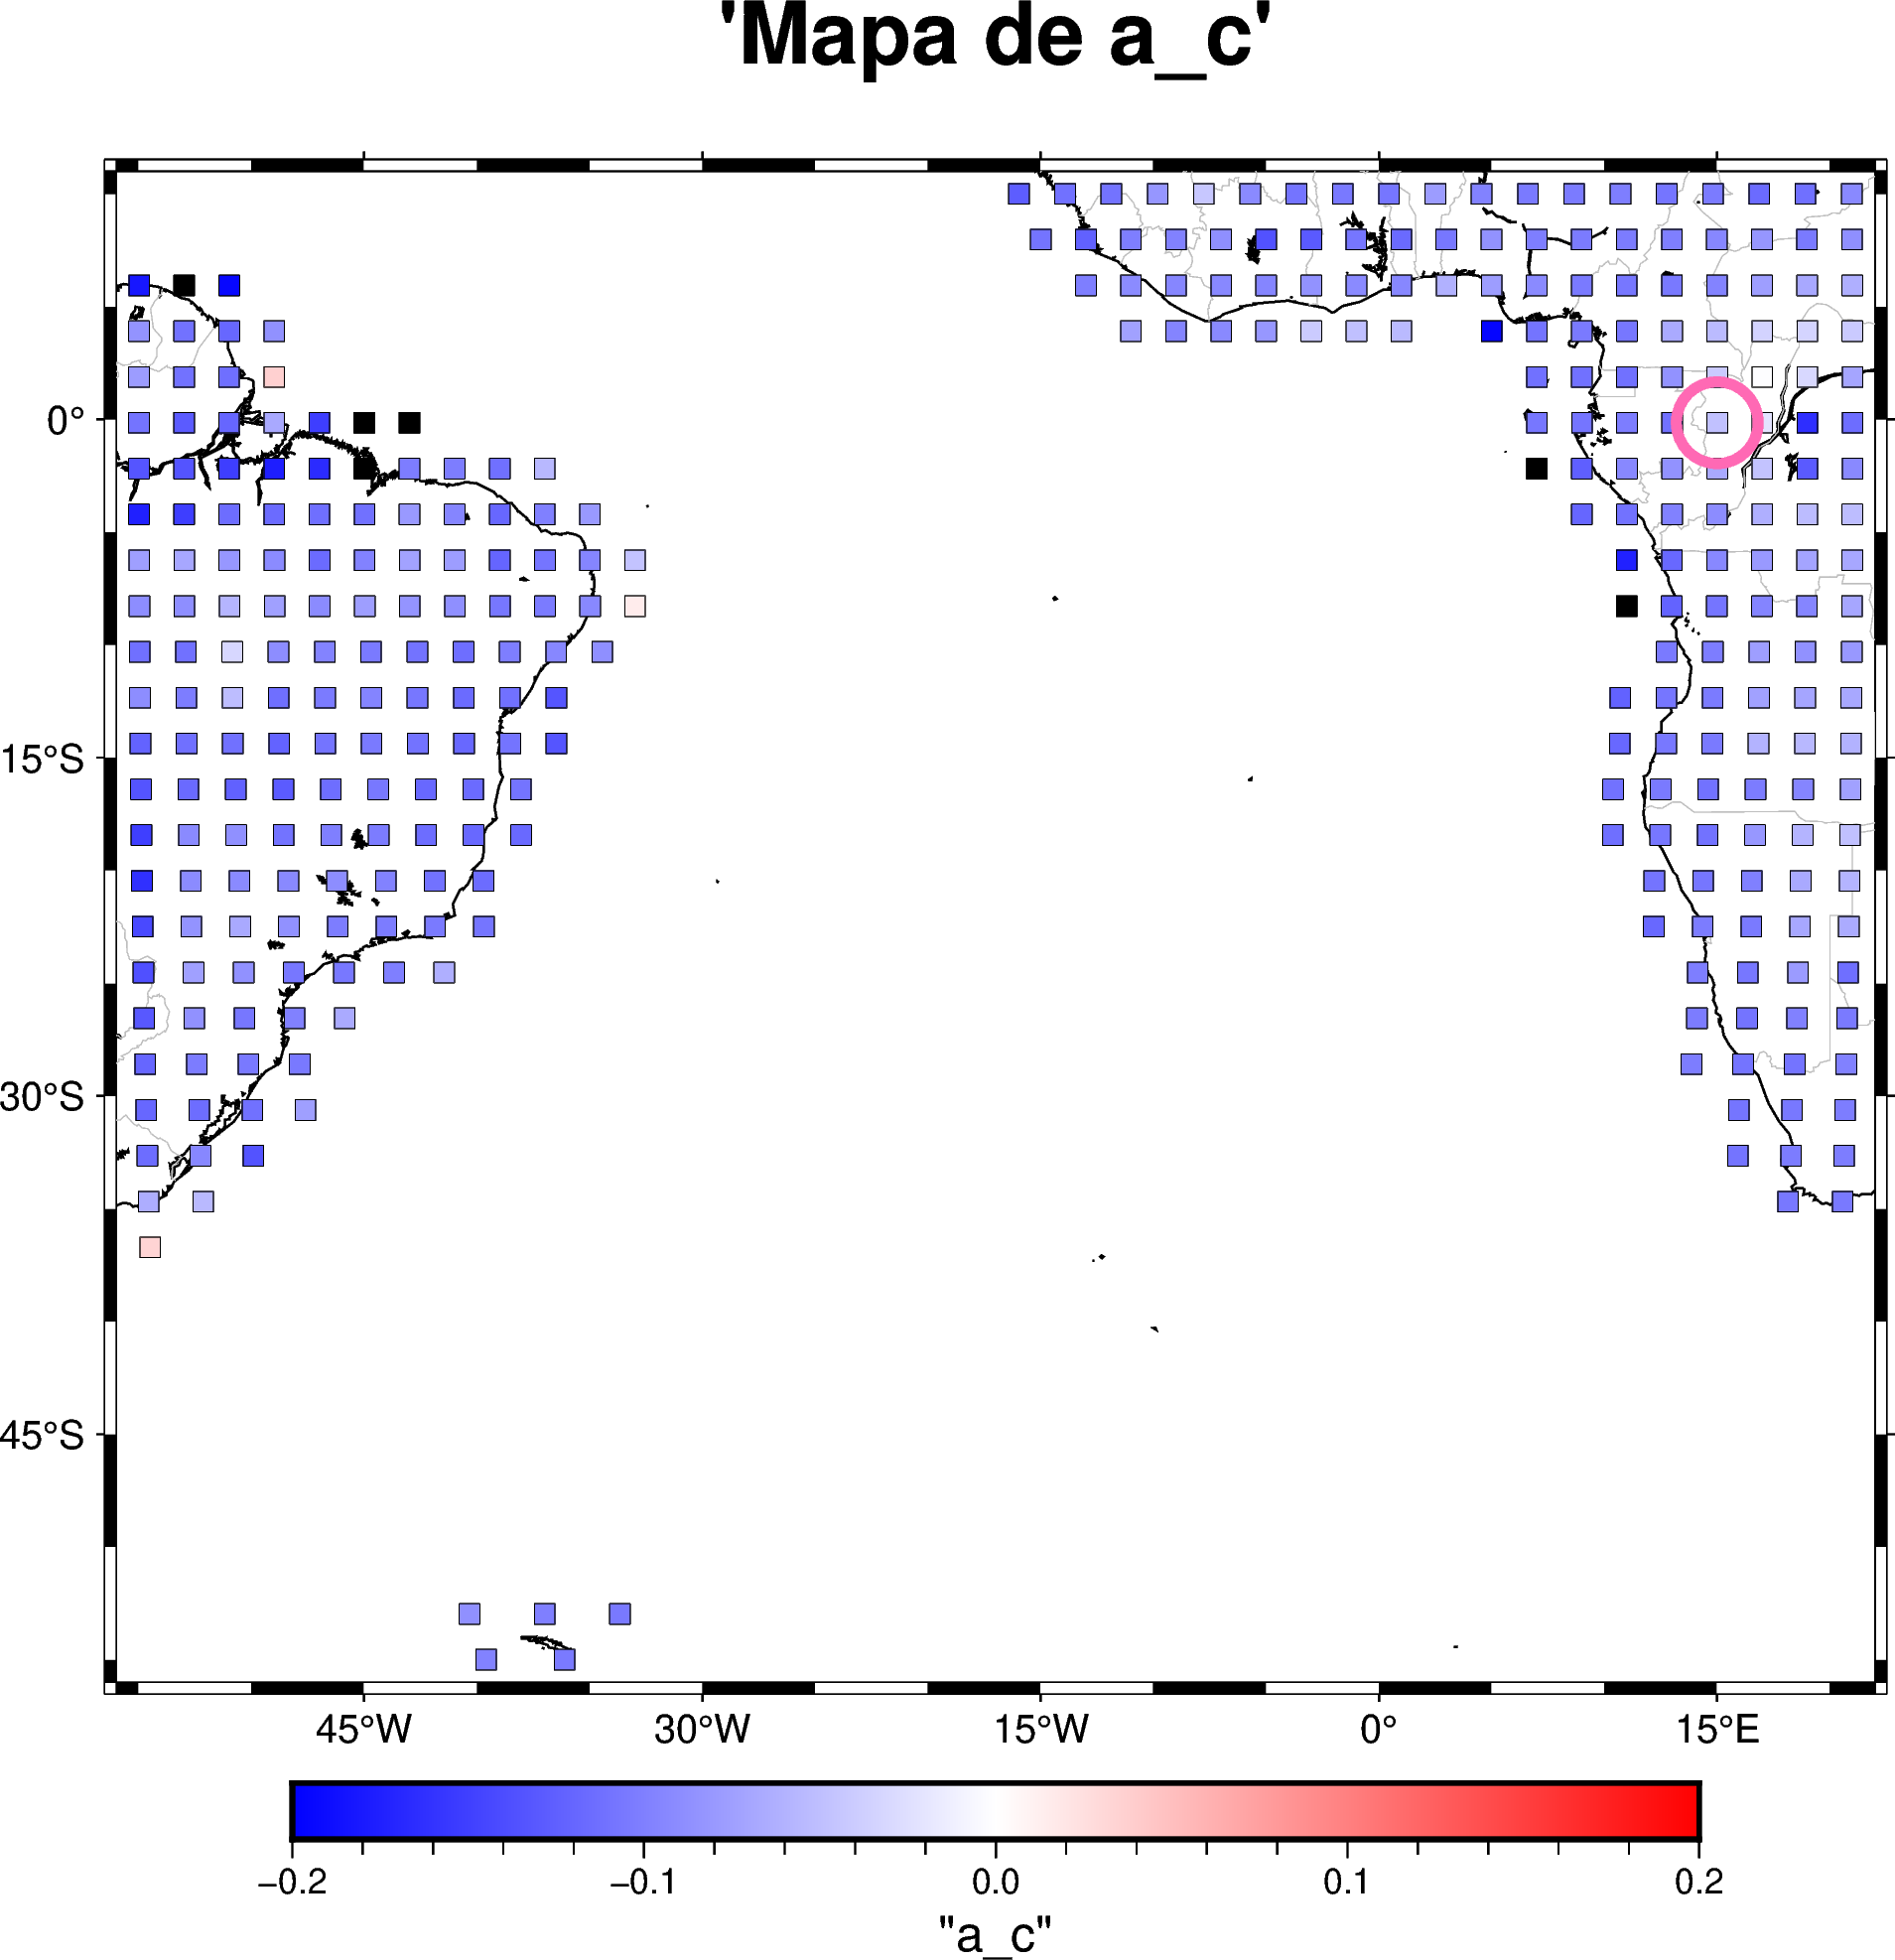

In [23]:
lon_alvo = df_windows.loc[window_minor_distance, 'longitude']
lat_alvo = df_windows.loc[window_minor_distance, 'latitude']

# 2. Gerar o mapa base (ele retorna o objeto 'fig')
fig = r.plot_parameters_map(df_windows, 'a_c', v_range=[-0.2, 0.2], step=0.01, cmap='polar', reverse=False, projection = 'Q')

# 3. Desenhar um círculo de destaque sobre o mapa
# Criamos um "efeito de borda" com dois círculos sobrepostos
fig.plot(
    x=lon_alvo, 
    y=lat_alvo, 
    style='c0.7c', 
    pen='2.5p,hotpink' 
)

print('O círculo rosa é a localização da janela.')
print()
fig.show()

# Acessando janela específica

In [24]:
# janela especifica que quero acessar
i_wished_window = 428
line_in_df = df_windows.loc[df_windows['original-idx'] == i_wished_window] # localizo original-idx

if not line_in_df.empty: # para caso a linha não esteja no df 
    lon = line_in_df['longitude'].values[0] # [0] para o pandas não bugar, ele ve values como filtro
    lat = line_in_df['latitude'].values[0]

    print(f'A janela {i_wished_window} tem coordenadas: Longitude {lon:.2f} e Latitude {lat:.2f}')

else:
    print(f'A janela não está no df e pode ter sido descartada ou está vazia')

line_in_df

A janela 428 tem coordenadas: Longitude 14.10 e Latitude -26.56


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
428,14.09975,-26.5625,-0.063397,-0.102325,28.426421,0.999525,428,440,328,112


In [25]:
idx_current = indices[i_wished_window][0]

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

# crio uma lista com os índices de h_window_raw que colocam o array em ordem numérica ex: [28, 3, 87] é o que deicaria o array em ordem
idx_sort = r.np.argsort(h_window_raw)
h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window, min_points = 5)
a_ocean_window, a_continent_window, intercept_window, r2_window = p_window

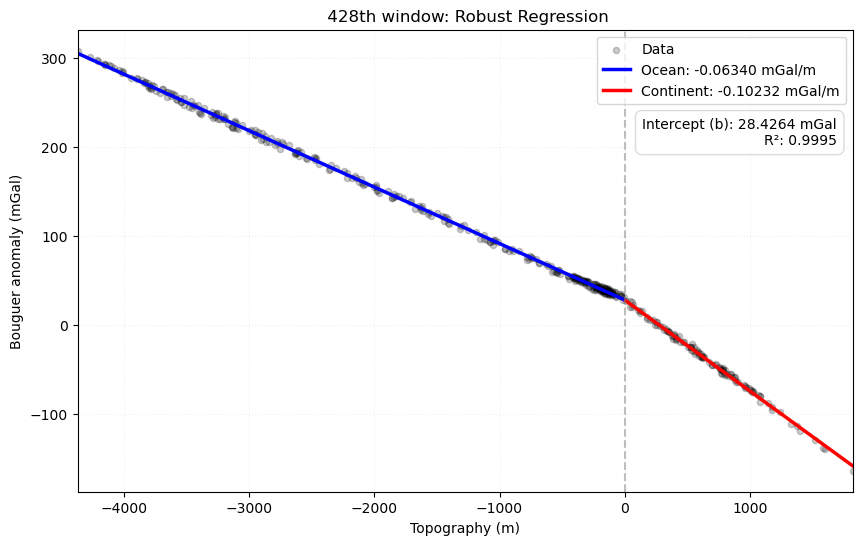

In [26]:
r.plot_window_regression(i_wished_window, h_window, d_window, a_ocean_window, a_continent_window, intercept_window, r2_window)

O círculo rosa é a localização da janela.



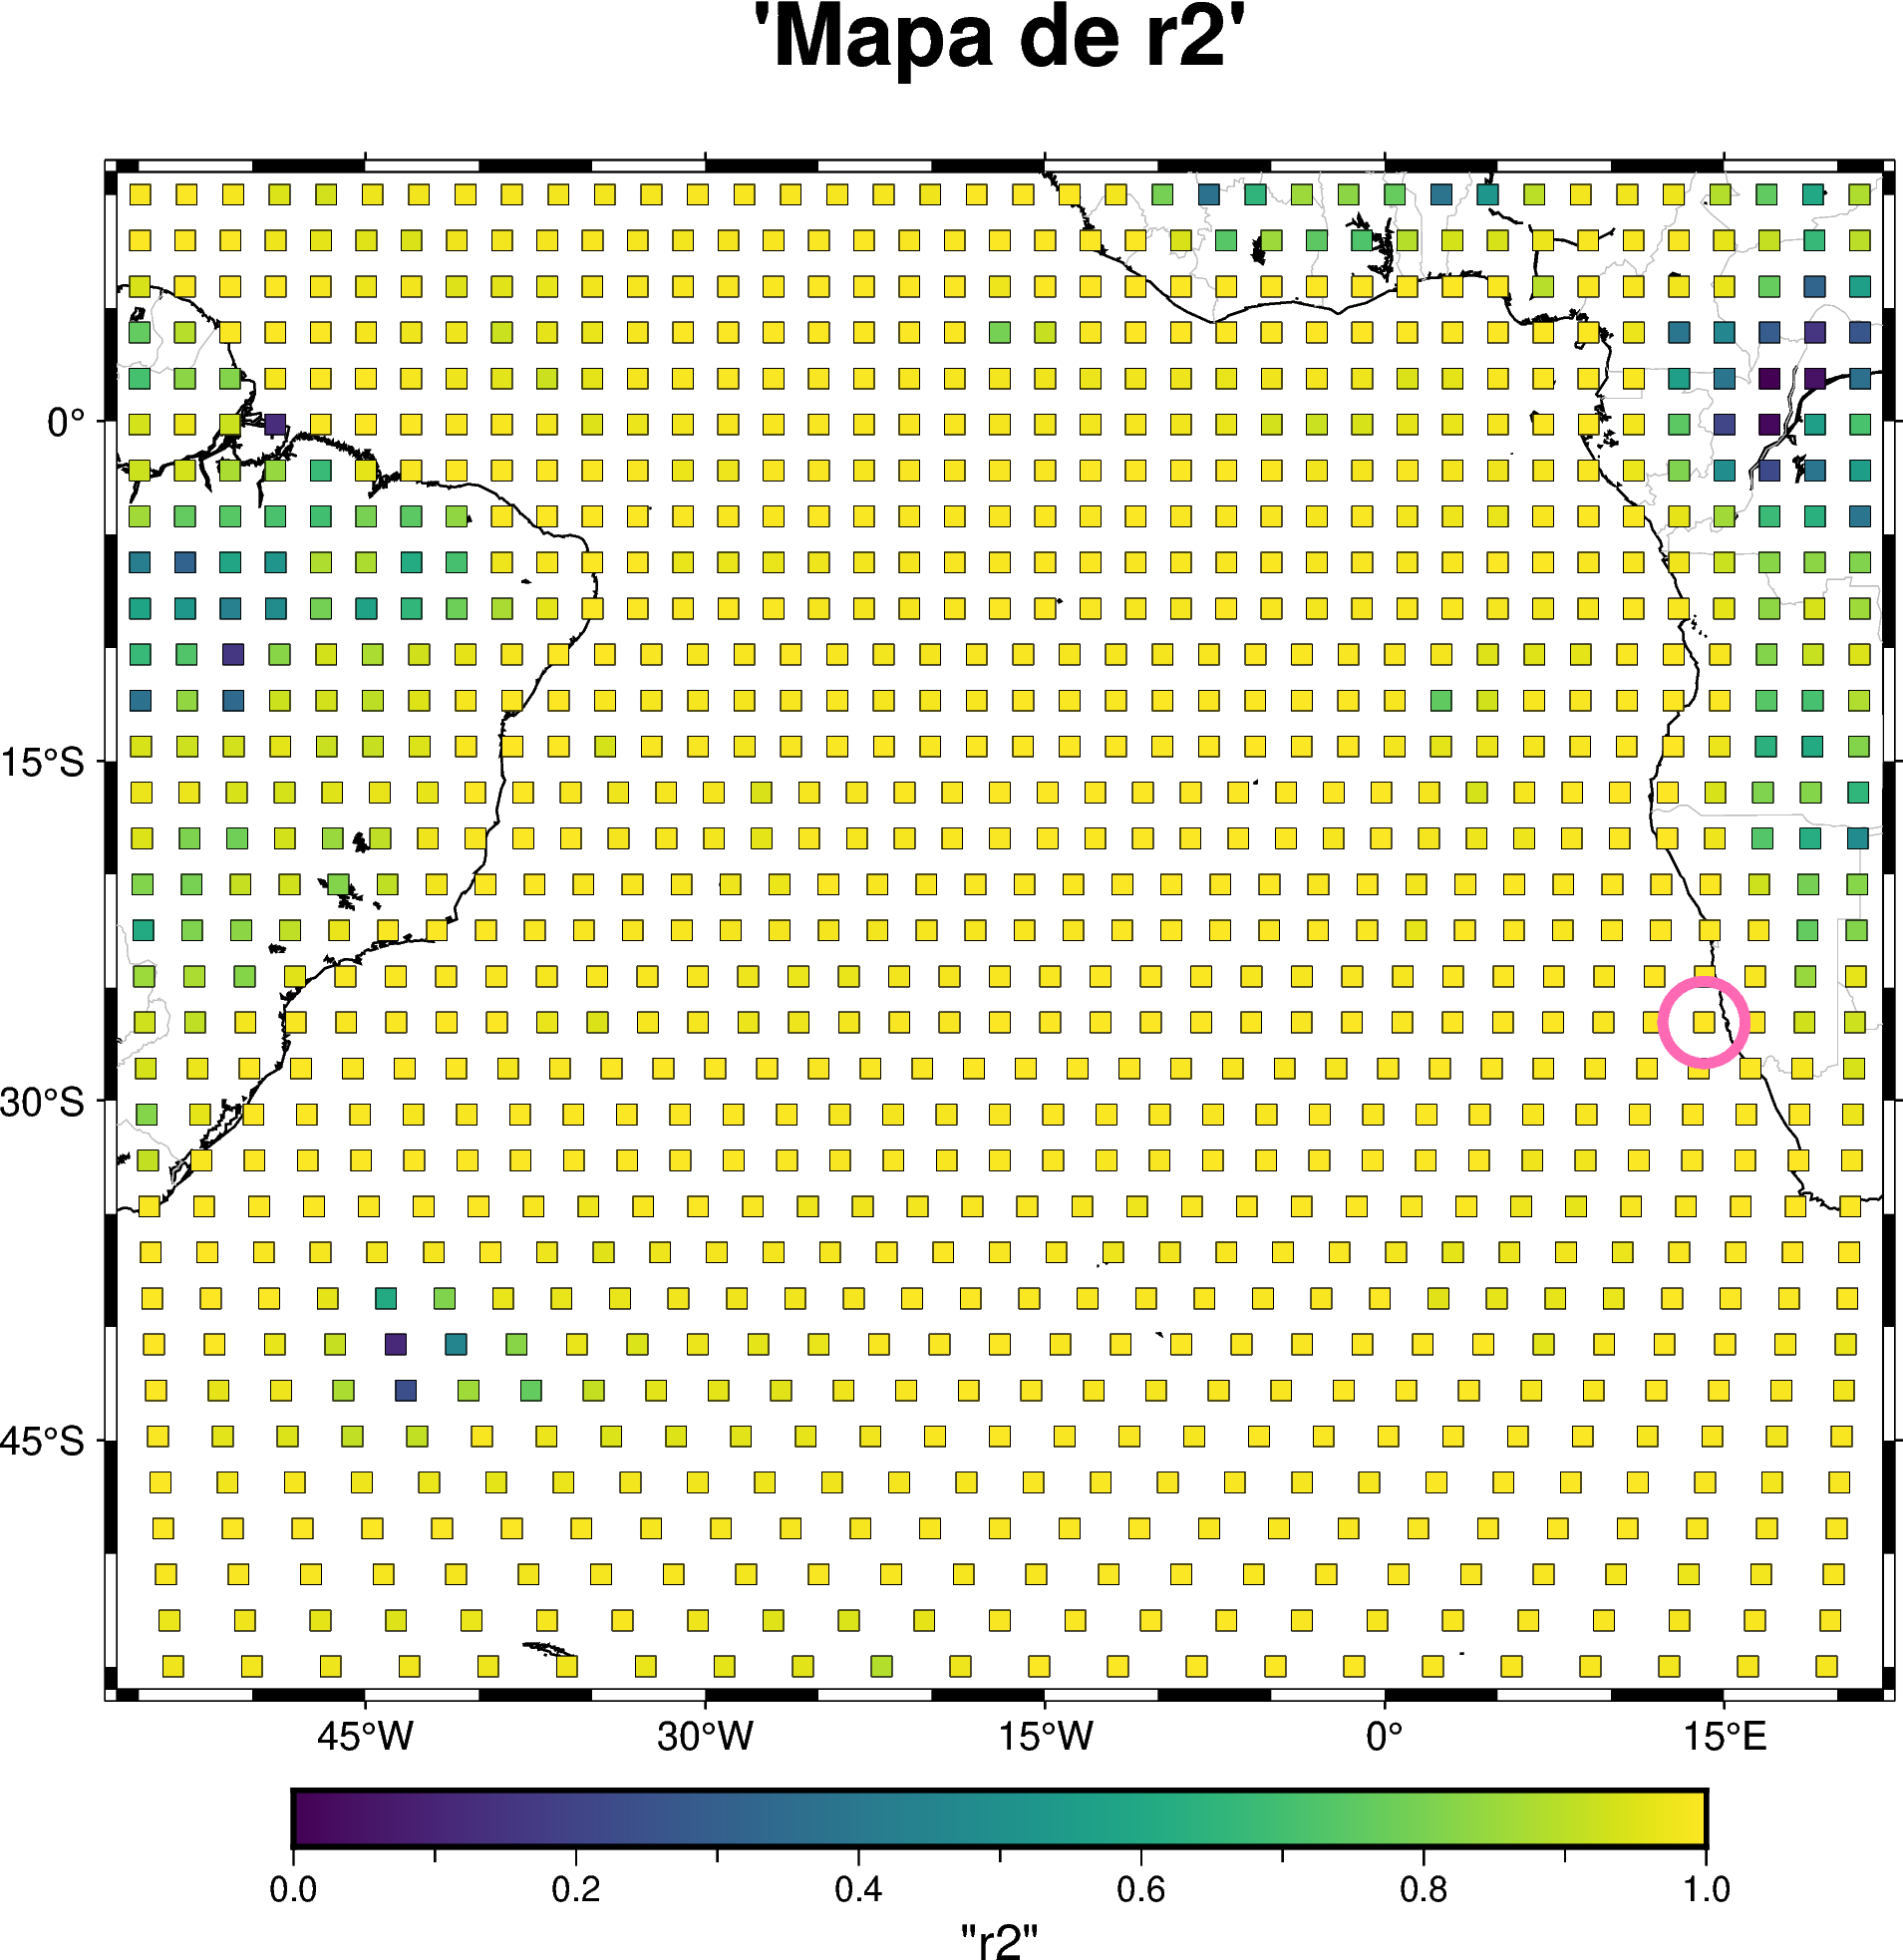

In [27]:

lon_alvo = df_windows.loc[i_wished_window, 'longitude']
lat_alvo = df_windows.loc[i_wished_window, 'latitude']

# 2. Gerar o mapa base (ele retorna o objeto 'fig')
fig = r.plot_parameters_map(df_windows, 'r2', v_range=[0, 1], step=0.01, cmap='viridis', reverse=False, projection = 'Q')

# 3. Desenhar um círculo de destaque sobre o mapa
# Criamos um "efeito de borda" com dois círculos sobrepostos
fig.plot(
    x=lon_alvo, 
    y=lat_alvo, 
    style='c0.7c',  # 'c' para circle, 0.7cm de tamanho
    pen='2.5p,hotpink' # Contorno branco grosso
)

print('O círculo rosa é a localização da janela.')
print()
fig.show()